In [33]:
import pymongo #資料庫
import pandas as pd #資料處理
import numpy #數據計算
from keras.layers.core import Dense,Activation,Dropout
from keras.layers import LSTM
from keras.models import Sequential
import matplotlib.pyplot as plt

In [34]:
# def loadstock_data(stock_num):
#查詢價量資料庫
#連結mongodb
stock_num = input("")
client = pymongo.MongoClient('mongodb://localhost:27017')
#連接資料庫
db = client['stock_data']    #資料庫
col_price = db["stock_price"]#價量資料
stock_data_p=col_price.find({"number":stock_num})#查詢資料庫
#刪除資料
# stock_data_p={"date":"2022/05/16"}#查詢資料庫
# x=col_price.delete_many(stock_data_p)


stock_p =  pd.DataFrame(list(stock_data_p))#轉成dataframe格式
# if len(stock_p) == 0:
#     stock_price_()#載入基本資料

stock_p=stock_p.sort_values(by=['date'],ascending=True)#排序日期
stock_p.index =pd.DatetimeIndex(stock_p['date'])
stock_p=stock_p.drop(['_id','date','number'],axis=1)
# stock_p = stock_p.loc["2020-01-02":"2021-05-1"]
foxconndf= stock_p
foxconndf.dropna(how='any',inplace=True)
foxconndf
    
    
    

2330


,open,high,low,close,volume
date,,,,,
2020-01-02,332.5,339.0,332.5,339.0,31656.0
2020-01-03,344.0,345.0,335.5,339.5,41811.0
2020-01-06,333.0,334.5,332.0,332.0,45343.0
2020-01-07,332.5,333.0,326.5,329.5,50879.0
2020-01-08,325.0,333.0,325.0,329.5,37568.0
...,...,...,...,...,...
2022-05-19,523.0,527.0,520.0,522.0,28843.0
2022-05-20,524.0,532.0,523.0,530.0,22980.0
2022-05-23,533.0,534.0,528.0,528.0,17007.0


In [35]:
from sklearn import preprocessing

def normalize(df):
    newdf= df.copy()
    min_max_scaler = preprocessing.MinMaxScaler()
    
    newdf['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    newdf['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    newdf['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    newdf['volume'] = min_max_scaler.fit_transform(df.volume.values.reshape(-1,1))
    newdf['close'] = min_max_scaler.fit_transform(df.close.values.reshape(-1,1))
    
    return newdf

foxconndf_norm= normalize(foxconndf)

In [36]:
import numpy as np

def data_helper(df, time_frame):
    
    # 資料維度: 開盤價、收盤價、最高價、最低價、成交量, 5維
    number_features = len(df.columns)

    # 將dataframe 轉成 numpy array
    datavalue = df.to_numpy()

    result = []
    # 若想要觀察的 time_frame 為20天, 需要多加一天做為驗證答案
    for index in range( len(datavalue) - (time_frame+1) ): # 從 datavalue 的第0個跑到倒數第 time_frame+1 個
        result.append(datavalue[index: index + (time_frame+1) ]) # 逐筆取出 time_frame+1 個K棒數值做為一筆 instance
    
    result = np.array(result)
    number_train = round(0.9 * result.shape[0]) # 取 result 的前90% instance做為訓練資料
    
    x_train = result[:int(number_train), :-1] # 訓練資料中, 只取每一個 time_frame 中除了最後一筆的所有資料做為feature
    y_train = result[:int(number_train), -1][:,-1] # 訓練資料中, 取每一個 time_frame 中最後一筆資料的最後一個數值(收盤價)做為答案
    
    # 測試資料
    x_test = result[int(number_train):, :-1]
    y_test = result[int(number_train):, -1][:,-1]
    
    # 將資料組成變好看一點
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], number_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], number_features))  

    return [x_train, y_train, x_test, y_test]

# 以20天為一區間進行股價預測
X_train, y_train, X_test, y_test = data_helper(foxconndf_norm, 20)

In [37]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import LSTM
import keras

def build_model(input_length, input_dim):
    d = 0.3
    model = Sequential()

    model.add(LSTM(256, input_shape=(input_length, input_dim), return_sequences=True))
    model.add(Dropout(d))

    model.add(LSTM(256, input_shape=(input_length, input_dim), return_sequences=False))
    model.add(Dropout(d))

    model.add(Dense(16,kernel_initializer="uniform",activation='relu'))
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))

    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])

    return model

# 20天、5維
model = build_model( 20, 5 )

In [38]:
# 一個batch有128個instance，總共跑50個迭代
model.fit( X_train, y_train, batch_size=128, epochs=50, validation_split=0.1, verbose=1)

Epoch 1/50
4/4 [==============================] - 4s 357ms/step - loss: 0.0600 - accuracy: 0.0000e+00 - val_loss: 0.0185 - val_accuracy: 0.0200
Epoch 2/50
4/4 [==============================] - 1s 154ms/step - loss: 0.0337 - accuracy: 0.0000e+00 - val_loss: 0.0240 - val_accuracy: 0.0200
Epoch 3/50
4/4 [==============================] - 1s 159ms/step - loss: 0.0247 - accuracy: 0.0000e+00 - val_loss: 0.0184 - val_accuracy: 0.0200
Epoch 4/50
4/4 [==============================] - 1s 142ms/step - loss: 0.0258 - accuracy: 0.0000e+00 - val_loss: 0.0184 - val_accuracy: 0.0200
Epoch 5/50
4/4 [==============================] - 1s 140ms/step - loss: 0.0239 - accuracy: 0.0000e+00 - val_loss: 0.0217 - val_accuracy: 0.0200
Epoch 6/50
4/4 [==============================] - 1s 162ms/step - loss: 0.0249 - accuracy: 0.0000e+00 - val_loss: 0.0192 - val_accuracy: 0.0200
Epoch 7/50
4/4 [==============================] - 1s 168ms/step - loss: 0.0246 - accuracy: 0.0000e+00 - val_loss: 0.0181 - val_accuracy:

In [39]:
def denormalize(df, norm_value):
    original_value = df['close'].values.reshape(-1,1)
    norm_value = norm_value.reshape(-1,1)
    
    min_max_scaler = preprocessing.MinMaxScaler()
    min_max_scaler.fit_transform(original_value)
    denorm_value = min_max_scaler.inverse_transform(norm_value)
    
    return denorm_value

# 用訓練好的 LSTM 模型對測試資料集進行預測
pred = model.predict(X_test)

# 將預測值與正確答案還原回原來的區間值
denorm_pred = denormalize(foxconndf, pred)
denorm_ytest = denormalize(foxconndf, y_test)

2/2 [==============================] - 1s 12ms/step


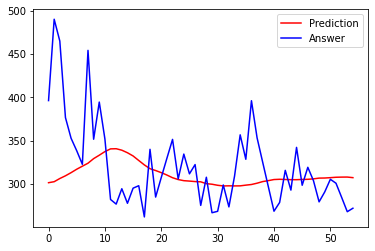

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline  

plt.plot(denorm_pred,color='red', label='Prediction')
plt.plot(denorm_ytest,color='blue', label='Answer')
plt.legend(loc='best')
plt.show()